<a href="https://colab.research.google.com/github/nipun-davasam/IA651-Applied-Machine-Learning/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import os
from keras.utils import to_categorical
from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dense,Dropout
from sklearn.model_selection import ParameterGrid
import cv2
from tensorflow.keras import layers, models, optimizers
from sklearn.utils import shuffle
from matplotlib.image import imread
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras import backend as K

## Reading files from Drive

In [4]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# fetching the kaggle auth file from drive
!mkdir -p ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/Machine Learning/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# downloading dataset from kaggle
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p "/content/drive/MyDrive/Colab Notebooks/Machine Learning/cell_images"

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# unzipping the compressed file from drive
! unzip "/content/drive/MyDrive/Colab Notebooks/Machine Learning/cell_images/cell-images-for-detecting-malaria.zip"

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [8]:
# assigning base directory to base_dir variable which holds all images after unzipping
base_dir = "/content/cell_images"
os.listdir(base_dir)

['Parasitized', 'cell_images', 'Uninfected']

In [9]:
# Path to infected and uninfected folders
parasitized_dir = base_dir+"/Parasitized"
uninfected_dir = base_dir+"/Uninfected"

print ('Total of Parasitized cell images available: ', len(os.listdir(parasitized_dir)))
print ('Total of Uninfected cell images available: ', len(os.listdir(uninfected_dir)))

Total of Parasitized cell images available:  13780
Total of Uninfected cell images available:  13780


In [10]:
# printing the shape each image
image_loc = parasitized_dir + "/C100P61ThinF_IMG_20150918_144104_cell_162.png"
print("Shape of individual image: ",imread(image_loc).shape)

Shape of individual image:  (148, 142, 3)


## DataPreprocessing

In [11]:
# function that reads from given path location and resizes
def read_images_from_folder(folder_path, label, resize_shape=(64, 64)):
    images = []
    labels = []
    filenames = os.listdir(folder_path)
    for filename in filenames:
        try:
            image = cv2.imread(os.path.join(folder_path, filename))
            if image is not None:
                # Resize the image to a common shape
                image = cv2.resize(image, resize_shape)
                # Scaling iamge pixel to range from [0, 1]
                image = image.astype('float32') / 255.0
                images.append(image)
                labels.append(label)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return images, labels

# Path to infected and uninfected folders
infected_folder = base_dir+"/Parasitized"
uninfected_folder = base_dir+"/Uninfected"

# relabeling the images
infected_images, infected_labels = read_images_from_folder(infected_folder, 1)
uninfected_images, uninfected_labels = read_images_from_folder(uninfected_folder, 0)

# Combining images and labels
images = infected_images + uninfected_images
labels = infected_labels + uninfected_labels

# Converting to iamges to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Spliting the dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=4)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Checking the shapes and lengths of train, validation, and test sets
print("Train set:", X_train.shape, y_train.shape)
# print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (24802, 64, 64, 3) (24802,)
Test set: (2756, 64, 64, 3) (2756,)


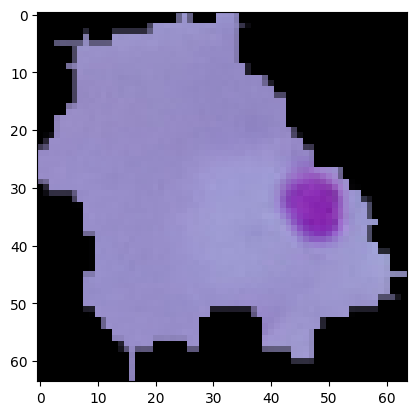

In [12]:
# sample after size reduction
plt.imshow(infected_images[200])

In [13]:
# function that plots accuracies and losses from the trained model
def plot_generator(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(history.history['accuracy'],marker='o')
    axs[0].plot(history.history['val_accuracy'],marker='x')
    axs[0].set_title('Model accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Train', 'Validation'], loc='center right')
    axs[0].grid()


    axs[1].plot(history.history['loss'],marker='o')
    axs[1].plot(history.history['val_loss'],marker='x')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Train', 'Validation'], loc='center right')
    axs[1].grid()

    plt.show()

## Random Samples

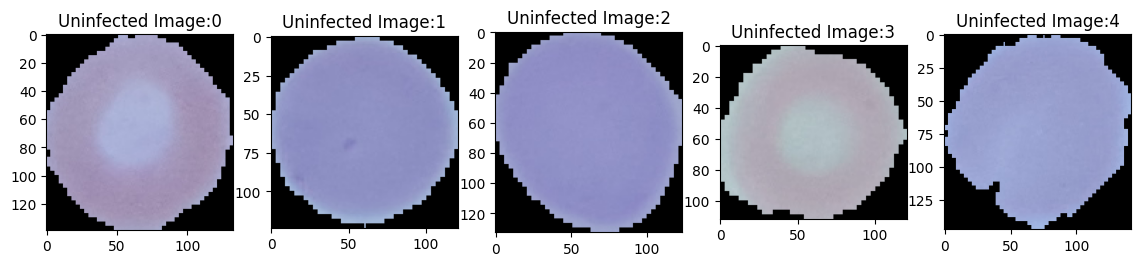

In [14]:
# printing 5 sample images of each type i.e., Uninfected samples
plt.figure(figsize=(14,14))
import random, cv2
for i in range(5):
    plt.subplot(2,5,i+1)
    type1 = "/Uninfected"
    imgdir = base_dir + type1
    imgfile = np.random.choice(os.listdir(imgdir))
    img = cv2.imread(imgdir + "/" + imgfile)
    plt.imshow(img)
    plt.title("Uninfected Image:"+str(i))
plt.show()

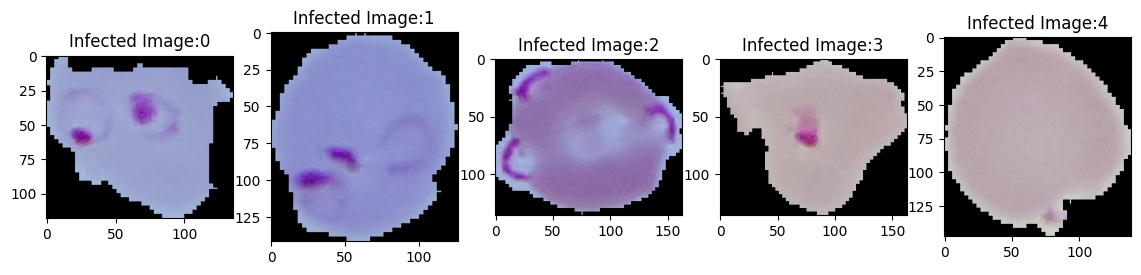

In [15]:
# printing 5 sample images of each type i.e., Infected samples
plt.figure(figsize=(14,14))
import random, cv2
for i in range(5):
    plt.subplot(2,5,i+1)
    type2 = "/Parasitized"
    imgdir = base_dir + type2
    imgfile = np.random.choice(os.listdir(imgdir))
    img = cv2.imread(imgdir + "/" + imgfile)
    plt.imshow(img)
    plt.title("Infected Image:"+str(i))
plt.show()

## Dataset distribution Pie Chart

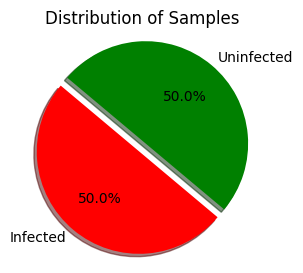

In [16]:
infected_samples = len(os.listdir(parasitized_dir))
uninfected_samples = len(os.listdir(uninfected_dir))

labels = ['Infected', 'Uninfected']
sizes = [infected_samples, uninfected_samples]
colors = ['red', 'green']
explode = (0.1,0)


plt.figure(figsize=(3,3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Samples')
plt.show()


## Simple CNN

In [ ]:
# generating the model
model1 = keras.Sequential([
    # adding convolution layers for 32 feature maps
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64,64,3),activation="relu"),
    # max pooling and picking the highest values
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # flattening the pixels and feeding it as input to neural network
    keras.layers.Flatten(),
    # inner layers of neural network
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    # output for  a binary classification
    keras.layers.Dense(2,activation='sigmoid')
])
# combining the model with desired output in our case categorical
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history1=model1.fit(X_train, y_train, validation_split=0.1,epochs=10)
# testing the model and printing its accuracy
test_loss1,test_acc1=model1.evaluate(X_test,y_test)
print('Test Accuracy of this model is: {:.3f}%'.format(test_acc1*100))

Epoch 1/10
698/698 [==============================] - 10s 7ms/step - loss: 0.2998 - accuracy: 0.8544 - val_loss: 0.1500 - val_accuracy: 0.9524
Epoch 2/10
698/698 [==============================] - 4s 5ms/step - loss: 0.1411 - accuracy: 0.9542 - val_loss: 0.1352 - val_accuracy: 0.9557
Epoch 3/10
698/698 [==============================] - 5s 7ms/step - loss: 0.1286 - accuracy: 0.9578 - val_loss: 0.1581 - val_accuracy: 0.9472
Epoch 4/10
698/698 [==============================] - 4s 5ms/step - loss: 0.1180 - accuracy: 0.9600 - val_loss: 0.1311 - val_accuracy: 0.9601
Epoch 5/10
698/698 [==============================] - 4s 6ms/step - loss: 0.1093 - accuracy: 0.9620 - val_loss: 0.1308 - val_accuracy: 0.9532
Epoch 6/10
698/698 [==============================] - 4s 6ms/step - loss: 0.0999 - accuracy: 0.9660 - val_loss: 0.1329 - val_accuracy: 0.9597
Epoch 7/10
698/698 [==============================] - 4s 6ms/step - loss: 0.0921 - accuracy: 0.9683 - val_loss: 0.1572 - val_accuracy: 0.9581
Epoch

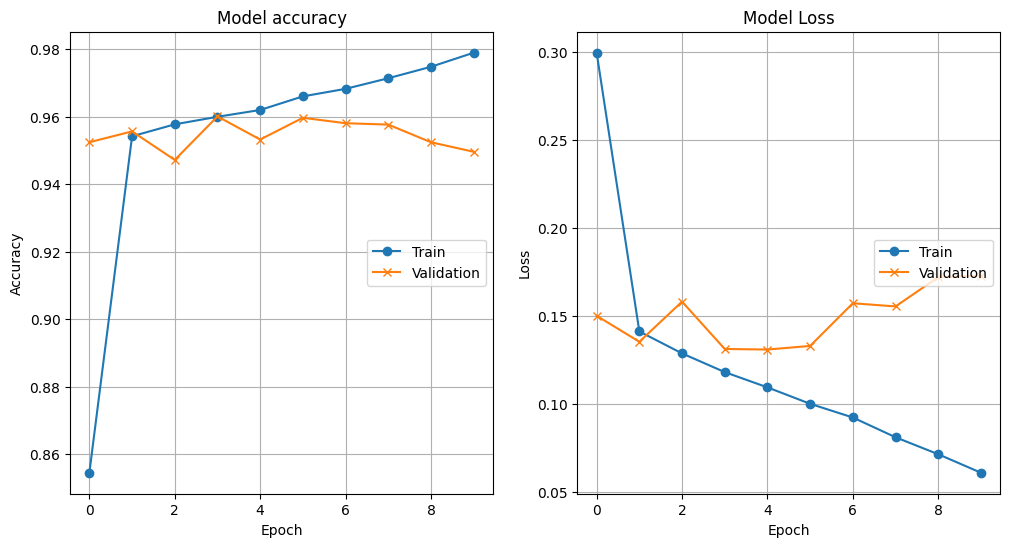

In [ ]:
# plot of accuracy and validation accuracy along another plot with loss and validation loss
plot_generator(history1)

In [ ]:
# model with ddropout to check its impact
model2 = keras.Sequential([
    # adding convolution layers for 32 feature maps
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64, 64,3),activation="relu"),
    # max pooling and picking the highest values
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # flattening the pixels and feeding it as input to neural network
    keras.layers.Flatten(),
     # inner layers of neural network
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    # adding dropout %
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    # output for  a binary classification
    keras.layers.Dense(2,activation='sigmoid')
])

# combining the model with desired output in our case categorical
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# training the model
history2=model2.fit(X_train, y_train, validation_split=0.1,epochs=10)
# testing the model and printing its accuracy
test_loss2,test_acc2=model2.evaluate(X_test,y_test)
print('Test Accuracy of this model is: {:.3f}%'.format(test_acc2*100))

Epoch 1/10
698/698 [==============================] - 9s 8ms/step - loss: 0.5042 - accuracy: 0.7084 - val_loss: 0.1733 - val_accuracy: 0.9488
Epoch 2/10
698/698 [==============================] - 4s 6ms/step - loss: 0.1564 - accuracy: 0.9538 - val_loss: 0.1504 - val_accuracy: 0.9585
Epoch 3/10
698/698 [==============================] - 4s 6ms/step - loss: 0.1373 - accuracy: 0.9575 - val_loss: 0.1406 - val_accuracy: 0.9597
Epoch 4/10
698/698 [==============================] - 5s 7ms/step - loss: 0.1263 - accuracy: 0.9581 - val_loss: 0.1382 - val_accuracy: 0.9601
Epoch 5/10
698/698 [==============================] - 4s 6ms/step - loss: 0.1171 - accuracy: 0.9621 - val_loss: 0.1432 - val_accuracy: 0.9613
Epoch 6/10
698/698 [==============================] - 4s 6ms/step - loss: 0.1097 - accuracy: 0.9637 - val_loss: 0.1654 - val_accuracy: 0.9508
Epoch 7/10
698/698 [==============================] - 5s 7ms/step - loss: 0.1024 - accuracy: 0.9658 - val_loss: 0.1594 - val_accuracy: 0.9532
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


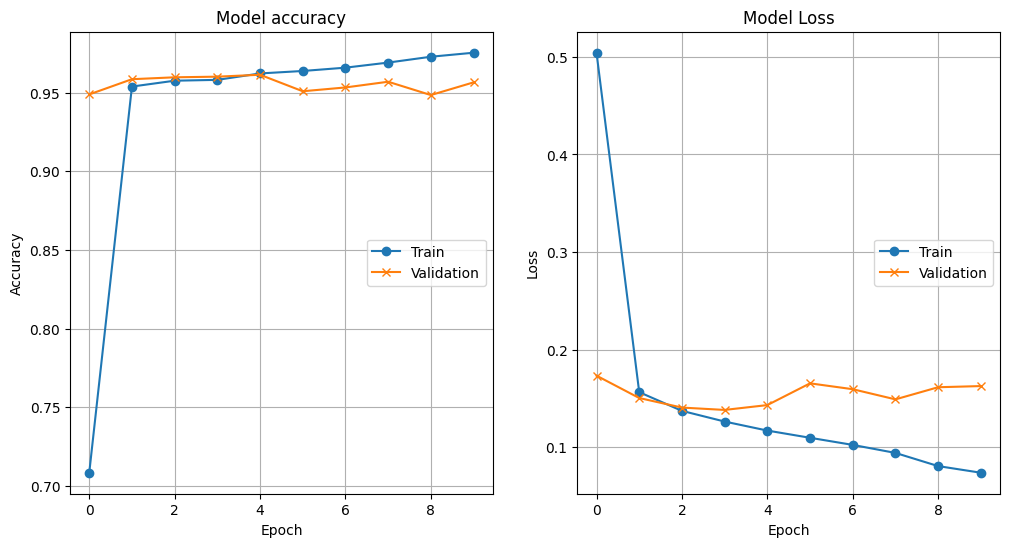

In [ ]:
# saving the model for further use and to avoid re-running the model again
model1.save("/content/drive/MyDrive/Colab Notebooks/Machine Learning/model_new.h5")
# plot of accuracy and validation accuracy along another plot with loss and validation loss
plot_generator(history1)

## Tuning hyperparameters and comparing results

In [ ]:
# generating combination of hyperparameters
hyperparameters=dict(layers=[3,4],nodes=[64,128],activation_func=['relu','sigmoid'],batch_size=[32,64])
hyperparamters_combinations=list(ParameterGrid(hyperparameters))
hyperparamters_combinations

[{'activation_func': 'relu', 'batch_size': 32, 'layers': 3, 'nodes': 64},
 {'activation_func': 'relu', 'batch_size': 32, 'layers': 3, 'nodes': 128},
 {'activation_func': 'relu', 'batch_size': 32, 'layers': 4, 'nodes': 64},
 {'activation_func': 'relu', 'batch_size': 32, 'layers': 4, 'nodes': 128},
 {'activation_func': 'relu', 'batch_size': 64, 'layers': 3, 'nodes': 64},
 {'activation_func': 'relu', 'batch_size': 64, 'layers': 3, 'nodes': 128},
 {'activation_func': 'relu', 'batch_size': 64, 'layers': 4, 'nodes': 64},
 {'activation_func': 'relu', 'batch_size': 64, 'layers': 4, 'nodes': 128},
 {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 3, 'nodes': 64},
 {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 3, 'nodes': 128},
 {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 4, 'nodes': 64},
 {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 4, 'nodes': 128},
 {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 3, 'nodes': 64},
 {'activation_fun

In [ ]:
# defining a function that can be reused for GridSearch
def model_generator(nodes,hidden_layers,activation_func,batch_size):
    _model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64, 64,3),activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten()])

    # creating layers
    for i in range(hidden_layers):
      # adding the passed activation function and number of nodes per layer
      _model.add(Dense(nodes,activation_func))

    _model.add(Dense(2,activation='sigmoid'))

    _model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return _model

In [ ]:
# GridSearch function to get the best parameters for out dataset
def GridSearchAlgo(model_generator,plot_generator,parameters,train_images, train_labels, test_images, test_labels):
  # variables to store best values
  global accuracy_plot
  accuracy_plot=[]
  global val_accuracy_plot
  val_accuracy_plot=[]
  global hyperparameters_plot
  hyperparameters_plot=[]
  best_accuracy=0
  best_params={}

  # iterating over 16 combinations
  for parameter in parameters:
    print("Hyperparameters being used is:",parameter)
    # model creating
    neural_model=model_generator(parameter.get('nodes'),parameter.get('layers'),parameter.get('activation_func'),parameter.get('batch_size'))
    # traing the model
    history=neural_model.fit(train_images,train_labels,epochs=10,validation_split=0.1,verbose=0)

    # plotting the accuracy and loss curves for the trained model
    plot_generator(history)

    # storing last training and validation accuracies for each hyperparameter combination
    accuracy_plot.append(history.history.get('accuracy')[-1])
    val_accuracy_plot.append(history.history.get('val_accuracy')[-1])

    test_loss,test_acc=neural_model.evaluate(test_images,test_labels)
    print('Test Accuracy of this model is: {:.3f}%'.format(test_acc*100))
    print('Validation Accuracy of this model is: {:.3f}%'.format(history.history.get('val_accuracy')[-1]*100))
    print('-'*150)

  ## checking for the best accuracy so far among the models
    if test_acc>best_accuracy:
      best_accuracy=test_acc
      best_params=parameter

# printing the best parameters after gridsearch
  print("Best Hyperparameters:",best_params)
  print("Best Accuracy: {:0.3}%".format(best_accuracy*100))
  return dict(accuracy=best_accuracy,params=best_params)

Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 32, 'layers': 3, 'nodes': 64}


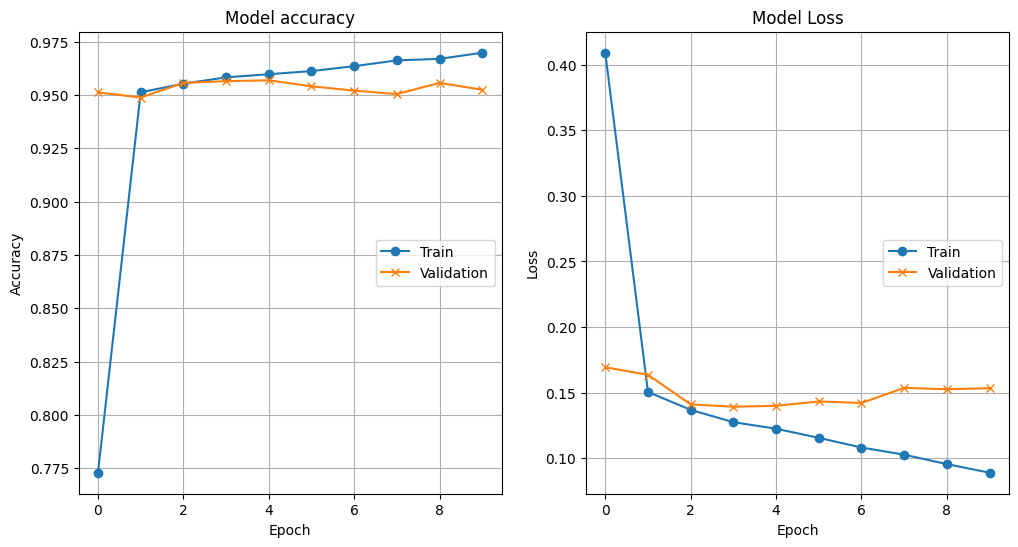

87/87 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9536
Test Accuracy of this model is: 95.356%
Validation Accuracy of this model is: 95.244%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 32, 'layers': 3, 'nodes': 128}


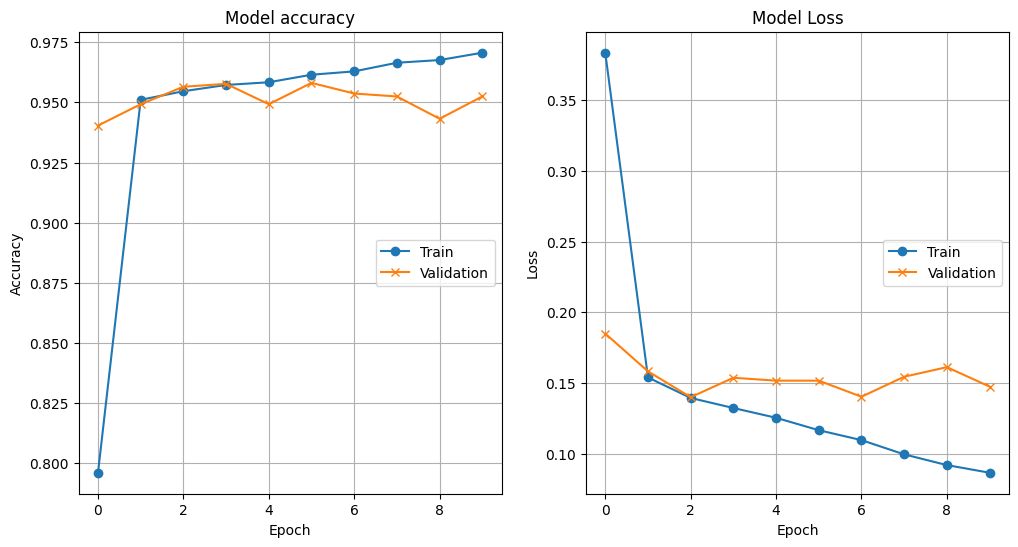

87/87 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.9521
Test Accuracy of this model is: 95.210%
Validation Accuracy of this model is: 95.244%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 32, 'layers': 4, 'nodes': 64}


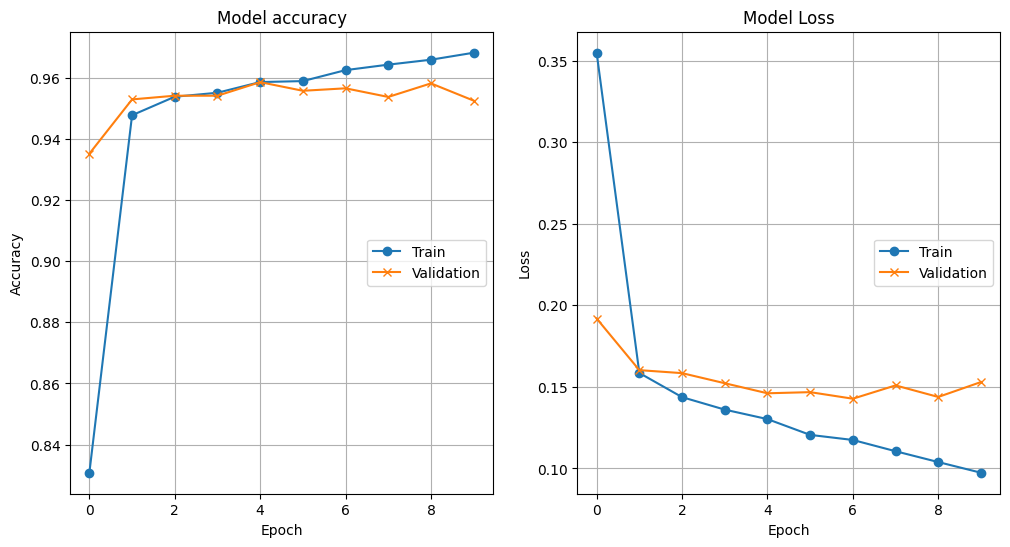

87/87 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9517
Test Accuracy of this model is: 95.174%
Validation Accuracy of this model is: 95.244%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 32, 'layers': 4, 'nodes': 128}


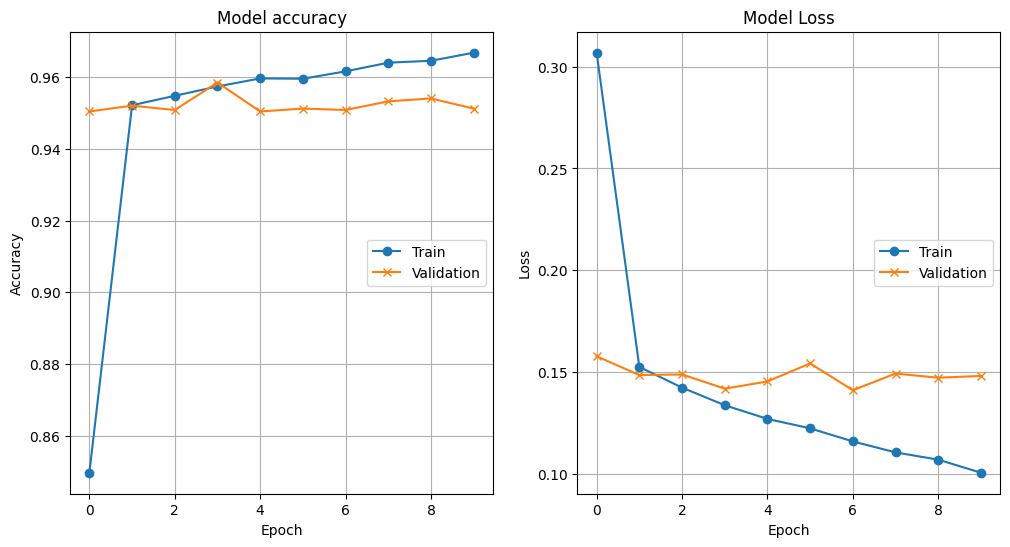

87/87 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9536
Test Accuracy of this model is: 95.356%
Validation Accuracy of this model is: 95.123%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 64, 'layers': 3, 'nodes': 64}


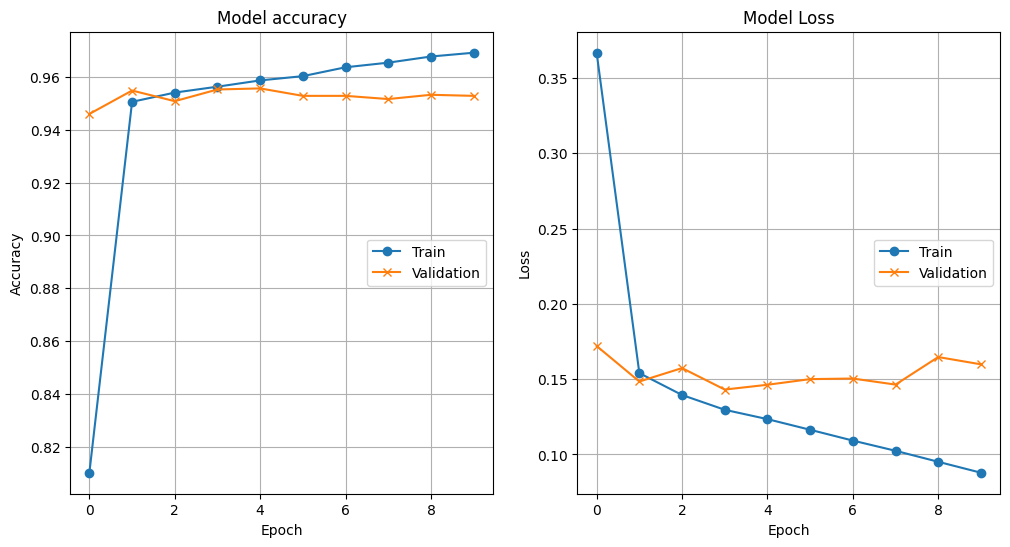

87/87 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.9521
Test Accuracy of this model is: 95.210%
Validation Accuracy of this model is: 95.284%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 64, 'layers': 3, 'nodes': 128}


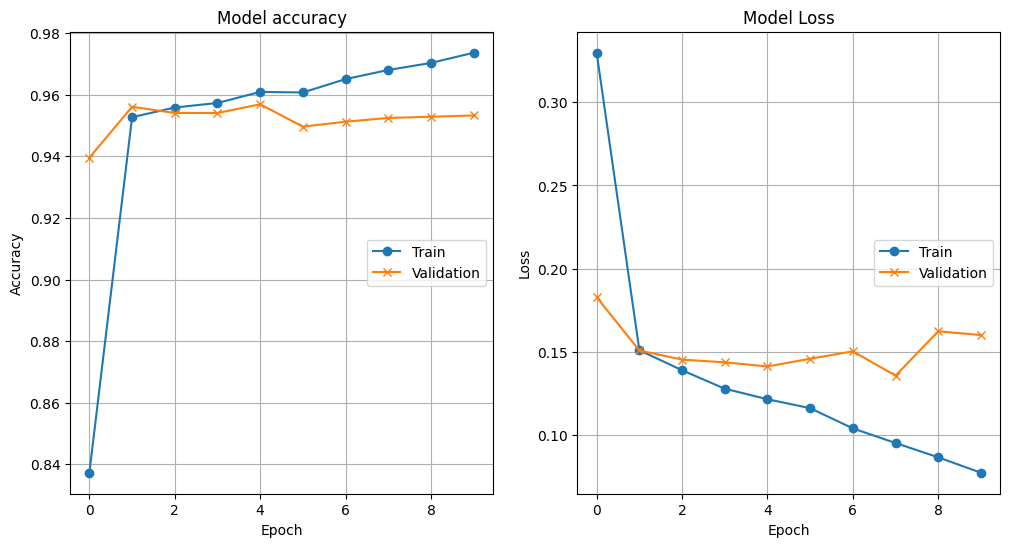

87/87 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9521
Test Accuracy of this model is: 95.210%
Validation Accuracy of this model is: 95.324%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 64, 'layers': 4, 'nodes': 64}


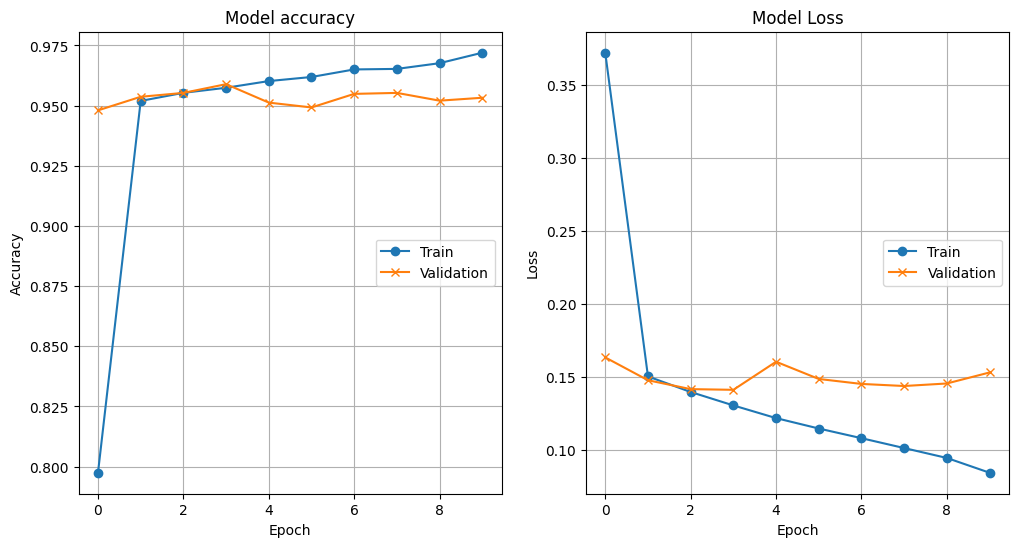

87/87 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9572
Test Accuracy of this model is: 95.718%
Validation Accuracy of this model is: 95.324%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'relu', 'batch_size': 64, 'layers': 4, 'nodes': 128}


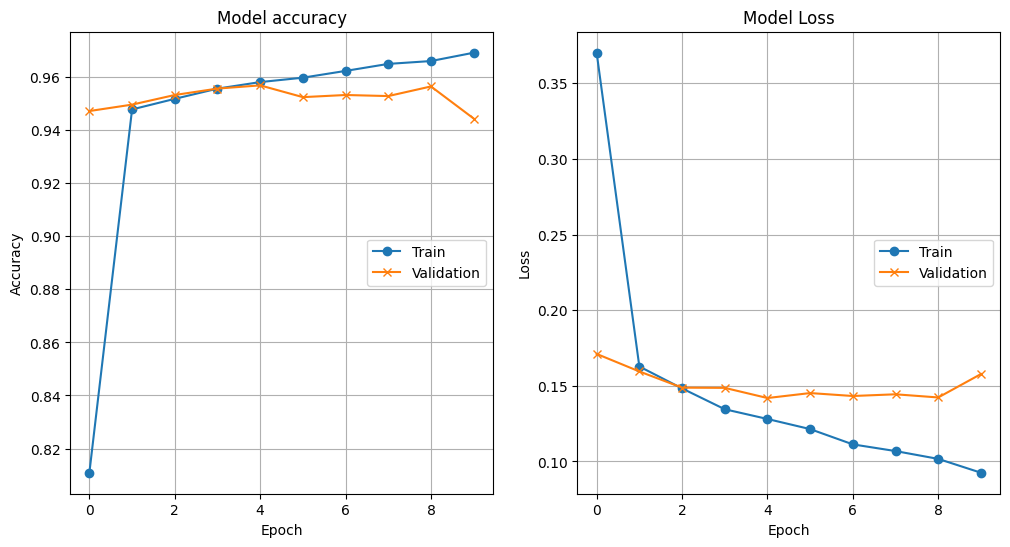

87/87 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9445
Test Accuracy of this model is: 94.448%
Validation Accuracy of this model is: 94.438%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 3, 'nodes': 64}


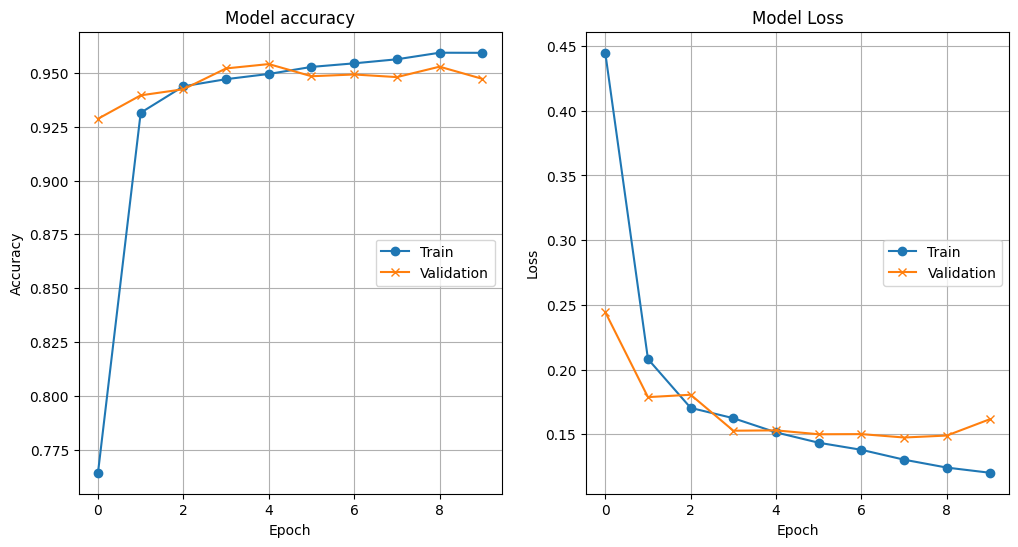

87/87 [==============================] - 0s 3ms/step - loss: 0.1729 - accuracy: 0.9496
Test Accuracy of this model is: 94.956%
Validation Accuracy of this model is: 94.720%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 3, 'nodes': 128}


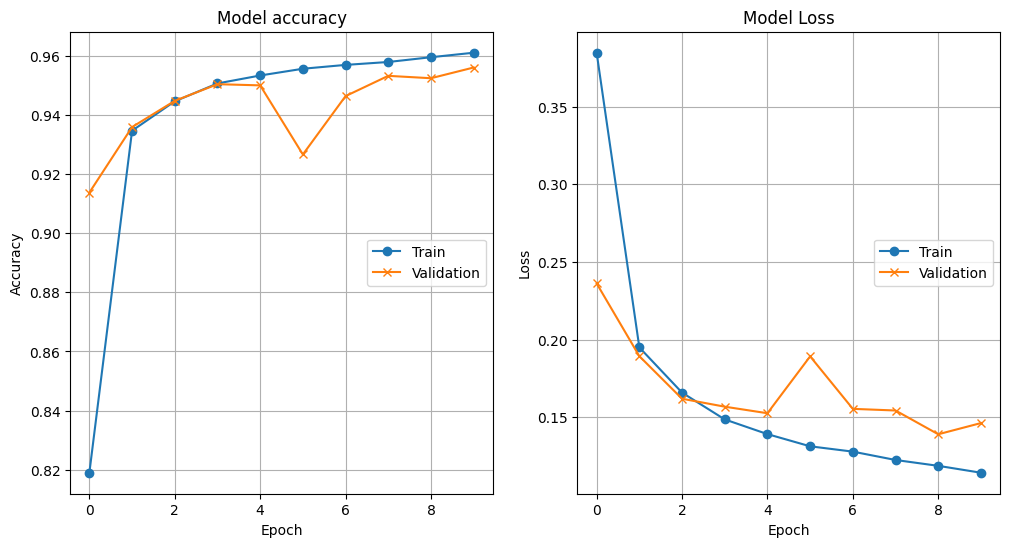

87/87 [==============================] - 0s 3ms/step - loss: 0.1546 - accuracy: 0.9521
Test Accuracy of this model is: 95.210%
Validation Accuracy of this model is: 95.607%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 4, 'nodes': 64}


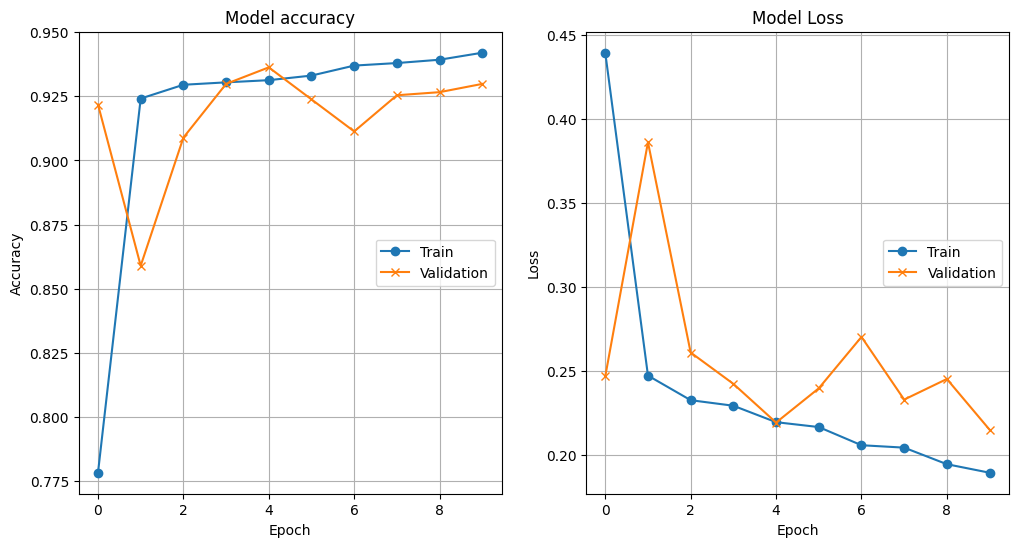

87/87 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.9318
Test Accuracy of this model is: 93.179%
Validation Accuracy of this model is: 92.987%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 32, 'layers': 4, 'nodes': 128}


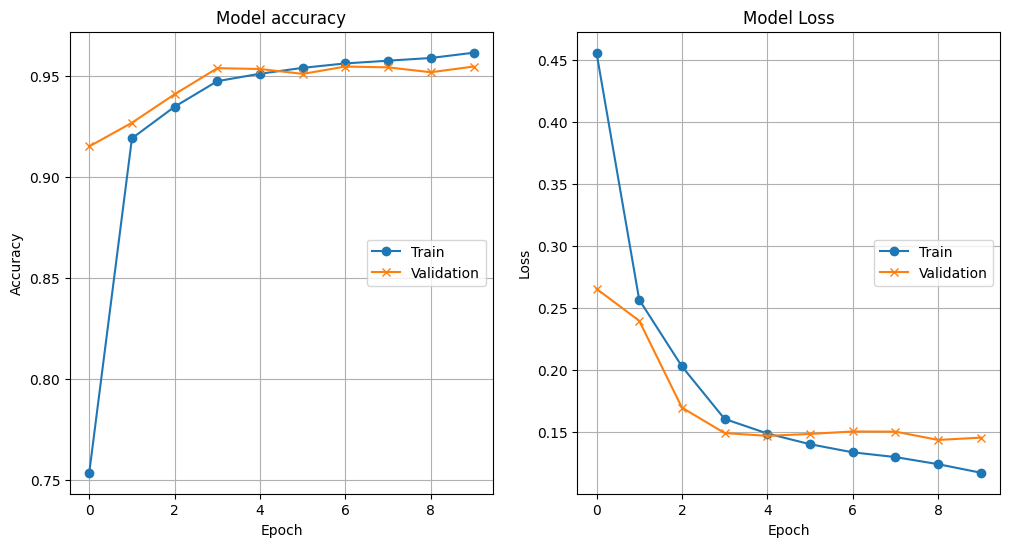

87/87 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9492
Test Accuracy of this model is: 94.920%
Validation Accuracy of this model is: 95.445%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 3, 'nodes': 64}


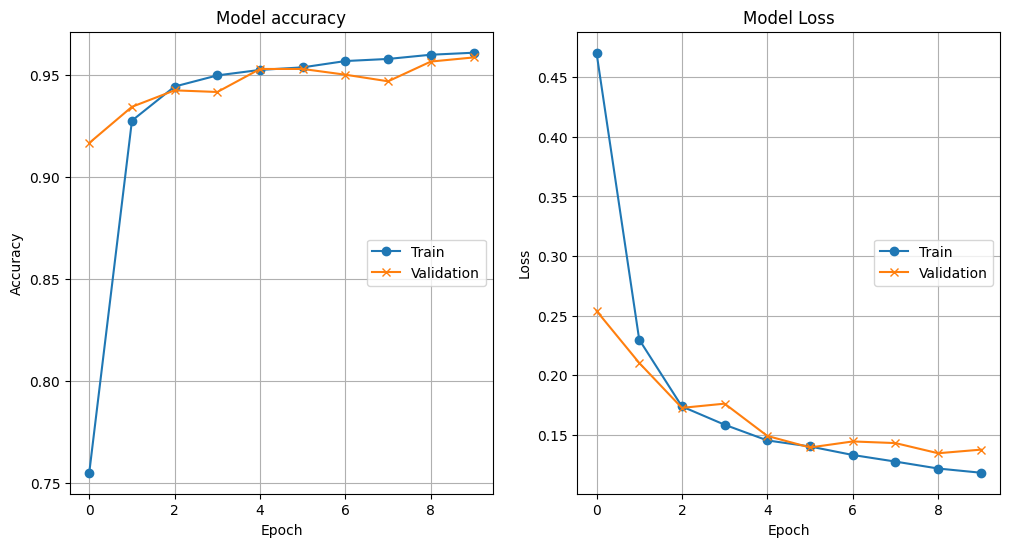

87/87 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9586
Test Accuracy of this model is: 95.864%
Validation Accuracy of this model is: 95.848%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 3, 'nodes': 128}


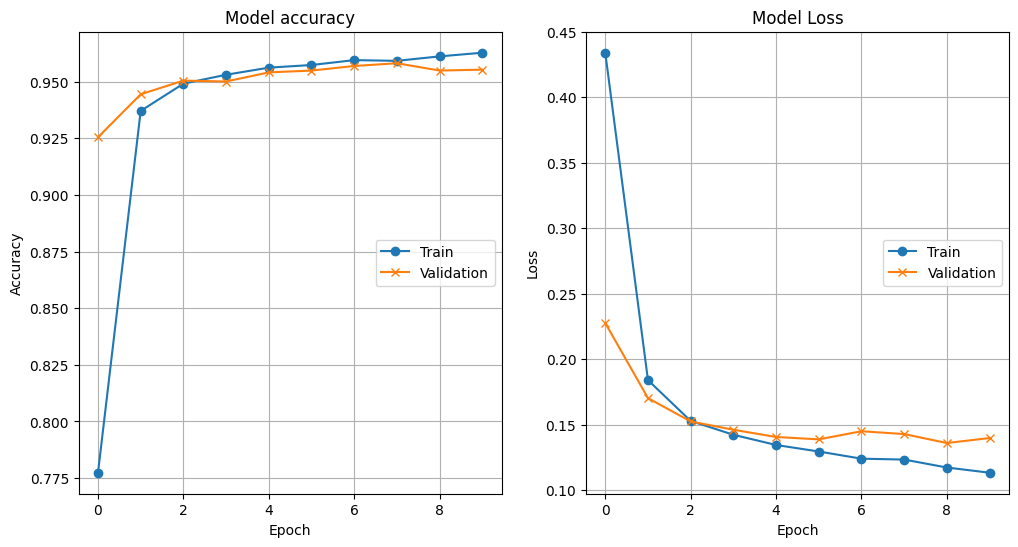

87/87 [==============================] - 0s 3ms/step - loss: 0.1506 - accuracy: 0.9572
Test Accuracy of this model is: 95.718%
Validation Accuracy of this model is: 95.526%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 4, 'nodes': 64}


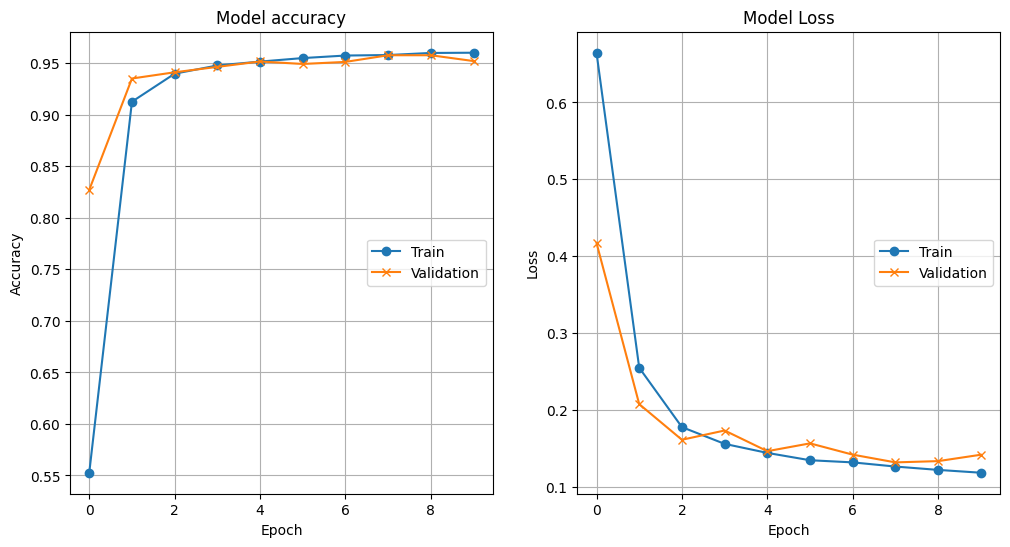

87/87 [==============================] - 0s 3ms/step - loss: 0.1577 - accuracy: 0.9510
Test Accuracy of this model is: 95.102%
Validation Accuracy of this model is: 95.204%
------------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters being used is: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 4, 'nodes': 128}


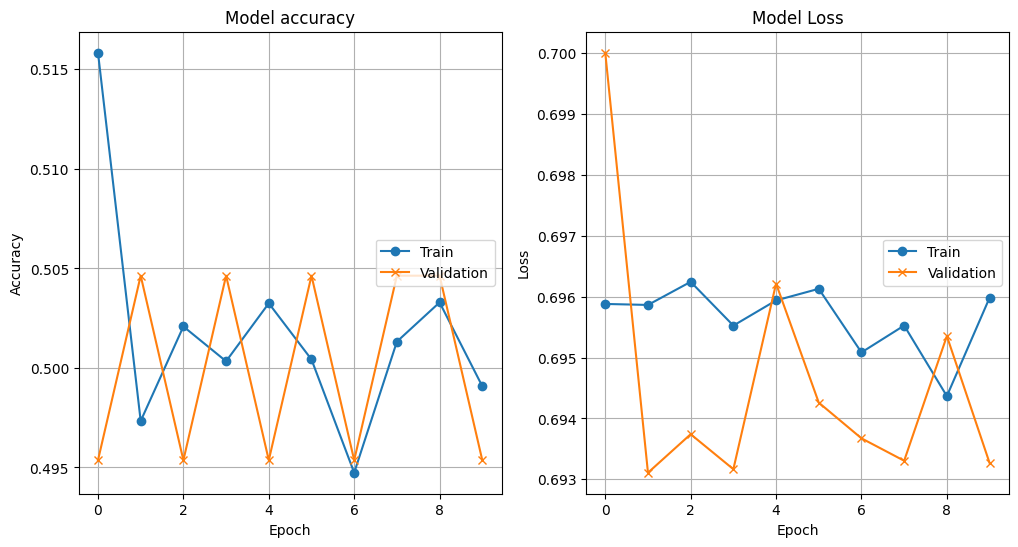

87/87 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4895
Test Accuracy of this model is: 48.948%
Validation Accuracy of this model is: 49.536%
------------------------------------------------------------------------------------------------------------------------------------------------------
Best Hyperparameters: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 3, 'nodes': 64}
Best Accuracy: 95.9%


In [ ]:
# output of gridsearch
result=GridSearchAlgo(model_generator,plot_generator,hyperparamters_combinations,X_train,y_train,X_test,y_test)

In [ ]:
#Using the best parameters for CNN from GridSearch

# Best Hyperparameters: {'activation_func': 'sigmoid', 'batch_size': 64, 'layers': 3, 'nodes': 64}
cnn_best = model_generator(64, 3, "sigmoid", 64)

#testing
history_cnn_best=cnn_best.fit(X_train,y_train,epochs=10,validation_split=0.1,verbose=0)

#printing the test accuracy
test_loss_cnn_best,test_acc_cnn_best=cnn_best.evaluate(X_test,y_test)
print('Test Accuracy of this model is: {:.3f}%'.format(test_acc_cnn_best*100))
cnn_best.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/model_best.h5')


87/87 [==============================] - 1s 6ms/step - loss: 0.1226 - accuracy: 0.9604
Test Accuracy of this model is: 96.045%


## Intermediate layers pixels picked

In [ ]:
# loading the saved model from drive
model_l = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/model_new.h5')

In [ ]:
# model summary to get the names for convolution layers to be used for plotting output intermediate layers
model_l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 6, 6, 32)         

In [ ]:
# type converting the image
raw_cell_image = image.img_to_array(infected_images[200])
raw_cell_image = np.expand_dims(raw_cell_image, axis=0)


layer_outputs = [layer.output for layer in model_l.layers[:6]]
activation_model = models.Model(inputs=model_l.input, outputs=layer_outputs)
# predicitng the image after passing to trained model
activations = activation_model.predict(raw_cell_image)
conv_indixes = []

# filtering out only convolution layers
for i in range(len(activations)):
    if( "conv2d" in model_l.layers[i].name) :
        conv_indixes.append(i)
        print("Layer: ", model_l.layers[i].name, " Shape: ", activations[i].shape)

1/1 [==============================] - 0s 116ms/step
Layer:  conv2d_3  Shape:  (1, 62, 62, 32)
Layer:  conv2d_4  Shape:  (1, 29, 29, 32)
Layer:  conv2d_5  Shape:  (1, 12, 12, 32)


In [ ]:
layer_outputs

[<KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 31, 31, 32) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 29, 29, 32) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'max_pooling2d_4')>,
 <KerasTensor: shape=(None, 12, 12, 32) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 6, 6, 32) dtype=float32 (created by layer 'max_pooling2d_5')>]

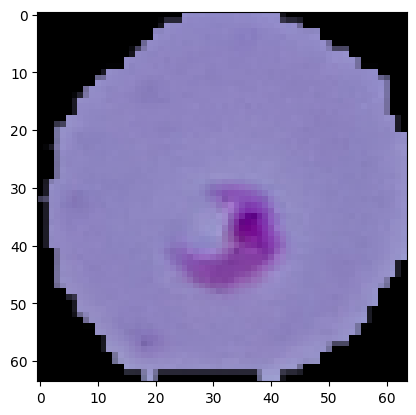

In [ ]:
# plotting a sample image
plt.imshow(infected_images[19])

Processing conv2d_3 layer...


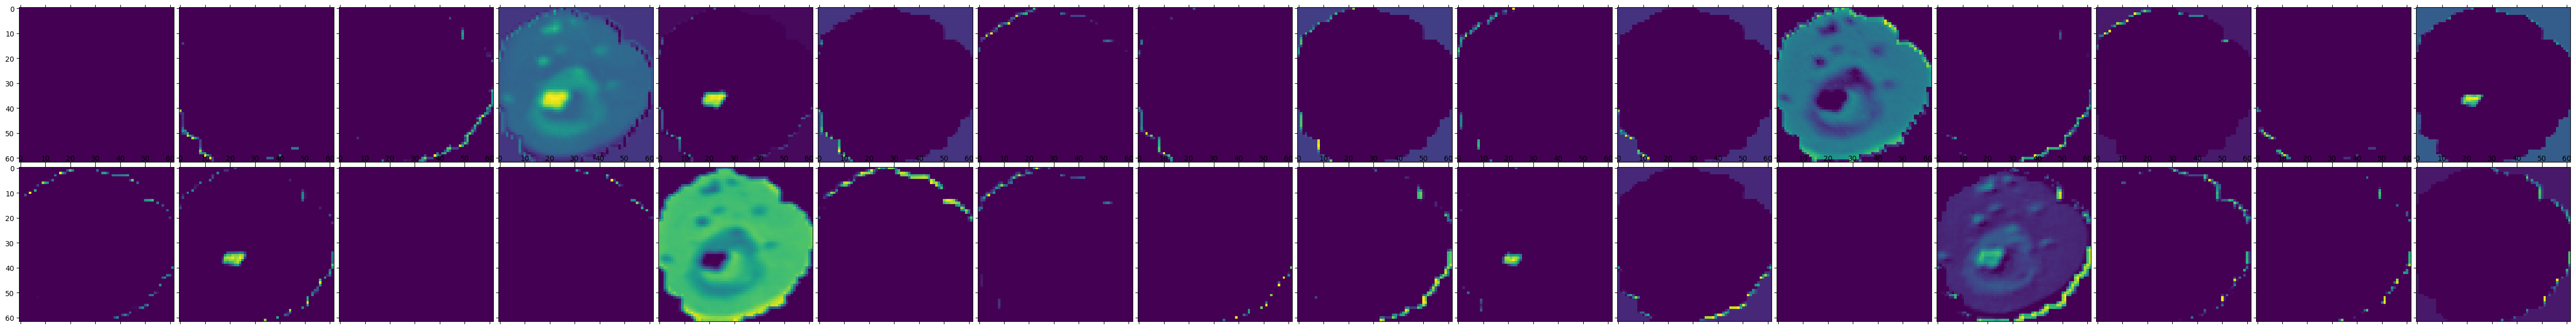

Processing conv2d_4 layer...


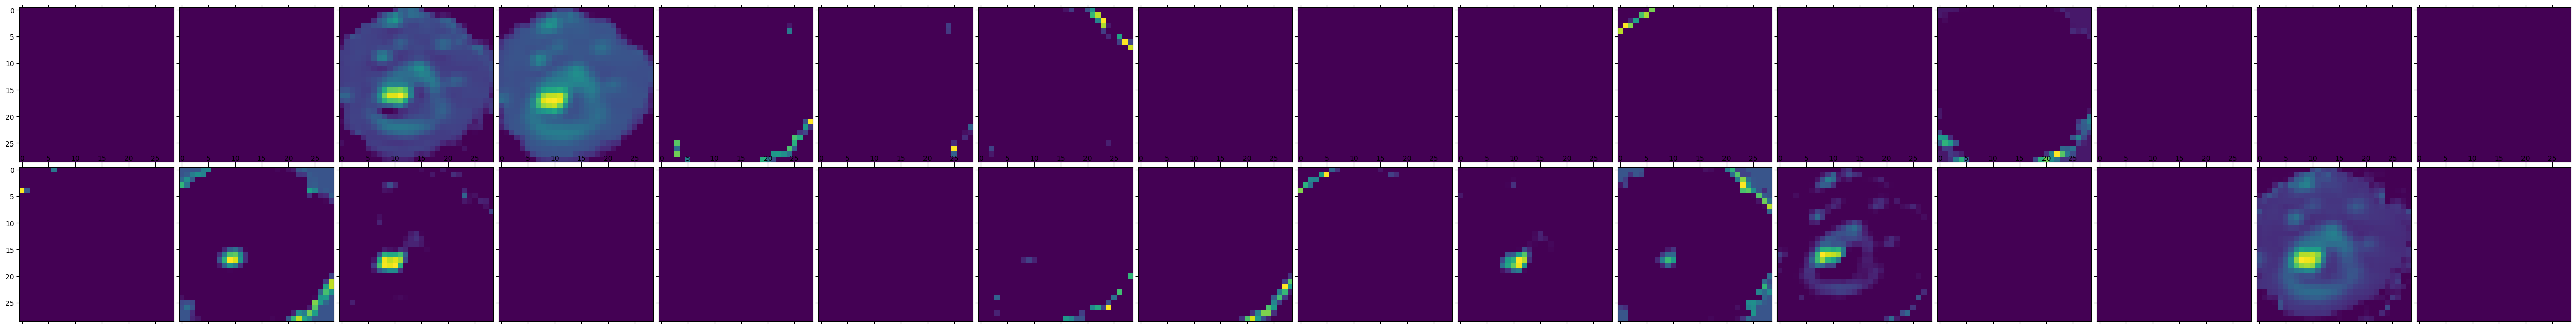

Processing conv2d_5 layer...


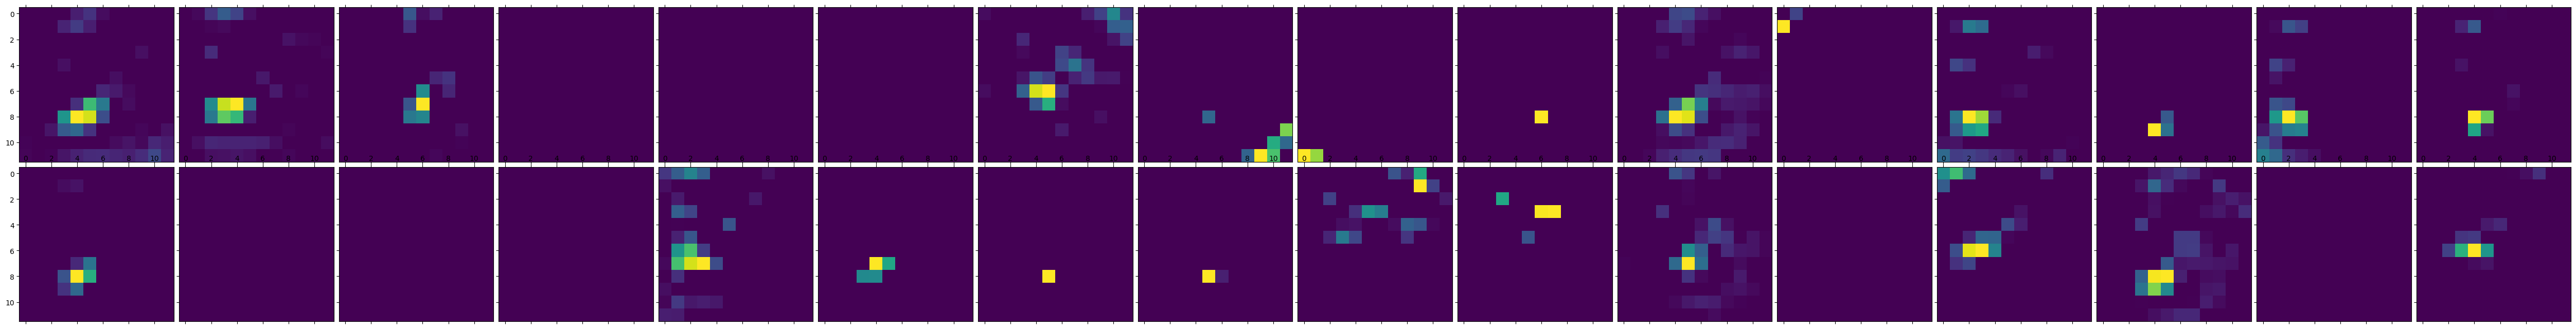

In [ ]:
# function that outputs intermediate layers of convolution from the model
def plot_layer(name, activation):
    print("Processing {} layer...".format(name))
    how_many_features_map = activation.shape[3]
   # Calculating the size of the figure based on the number of feature maps
    figure_size = how_many_features_map * 2

    # Creating a new figure plot with specified size
    fig = plt.figure(figsize=(figure_size, figure_size),)

    # Create a grid of axes for displaying feature maps
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(how_many_features_map // 16, 16),
                     axes_pad=0.1,  # padding between axes
                     )

    # Extracting individual feature maps from the activation tensor
    images = [activation[0, :, :, i] for i in range(how_many_features_map)]

    for ax, img in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.matshow(img)
    plt.show()

#for each conv2d layer plotting the feature maps
for i, conv_ix in enumerate(conv_indixes):
    plot_layer(model_l.layers[conv_ix].name, activations[conv_ix])

### Misclassified samples in the dataset

In [ ]:
predictions = model_l.predict(X_test)

87/87 [==============================] - 0s 3ms/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
# filtering the images that werent predicted by the model
misclassified_indices = np.where(predicted_labels != y_test)[0]
misclassified_indices

array([  83,  211,  257,  282,  345,  399,  400,  507,  514,  636,  659,
        681,  826,  834,  837,  843,  901, 1041, 1044, 1106, 1139, 1153,
       1157, 1162, 1273, 1274, 1280, 1354, 1410, 1448, 1519, 1561, 1590,
       1591, 1598, 1605, 1690, 1711, 1761, 1773, 1796, 1814, 1974, 2036,
       2086, 2176, 2214, 2333, 2349, 2357, 2358, 2363, 2371, 2411, 2428,
       2452, 2494, 2583, 2609, 2630, 2711, 2751, 2753])

False Predictions on test images


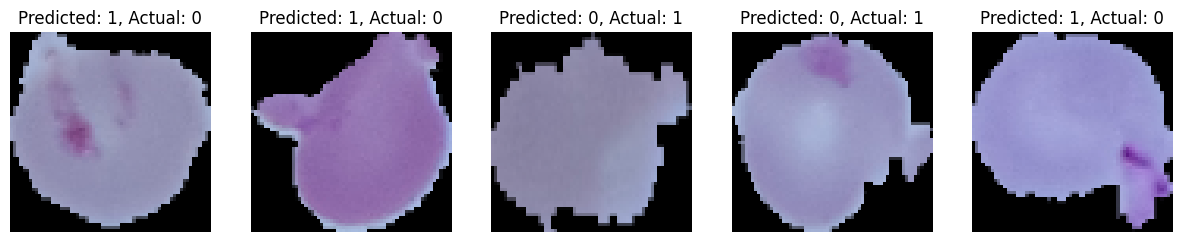

In [ ]:
# plotting samples that were mis-identified by the model
num_samples_to_visualize = 5
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(15, 3))

print('False Predictions on test images')
for i in range(num_samples_to_visualize):
    index = misclassified_indices[i]
    predicted_label = predicted_labels[index]
    ground_truth_label = y_test[index]
    axes[i].imshow(X_test[index])
    axes[i].set_title(f"Predicted: {predicted_label}, Actual: {ground_truth_label}")
    axes[i].axis('off')

plt.show()

### Correctly classified samples

In [ ]:
# filtering the images that were predicted by the model
classified_indices = np.where(predicted_labels == y_test)[0]
classified_indices

array([   0,    1,    2, ..., 2753, 2754, 2755])

True Predictions on test images


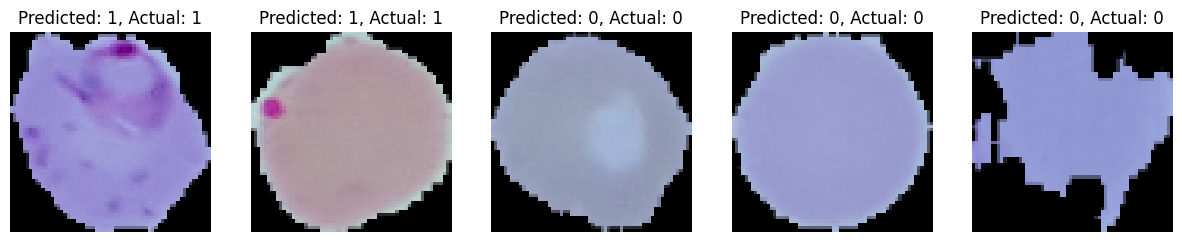

In [ ]:
# plotting 5 samples that were ms identified by the model
num_samples_to_visualize = 5
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(15, 3))

print('True Predictions on test images')
for i in range(num_samples_to_visualize):
    index = classified_indices[i]
    predicted_label = predicted_labels[index]
    ground_truth_label = y_test[index]
    axes[i].imshow(X_test[index])
    axes[i].set_title(f"Predicted: {predicted_label}, Actual: {ground_truth_label}")
    axes[i].axis('off')

plt.show()

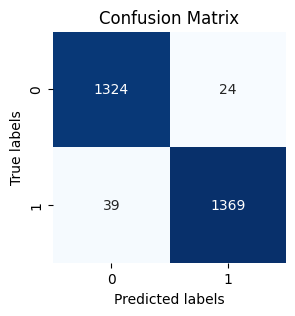

In [ ]:
# confusion matrix for the stored model
cm = confusion_matrix(y_test, predicted_labels)

# Plotting confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print('Accuracy of this model is: {:.3f}%'.format(accuracy*100))

Accuracy of this model is: 97.714%


## ResNet Network

In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    # Defining a residual block function that takes input x, number of filters, kernel size, strides, and activation function
    y = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    y = layers.Conv2D(filters, kernel_size, padding='same')(y)  # Removed strides
    y = layers.BatchNormalization()(y)

     # Apply identity mapping if the input shape or strides differ
    if strides != (1, 1) or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)

    # Adding the original input to the output of the residual block
    y = layers.add([x, y])
    y = layers.Activation(activation)(y)
    return y



def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initialising convolutional layer followed by batch normalization, activation, and max pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual stages: stacking residual blocks with increasing number of filters
    for filters in [64] * 2 + [128] * 2 + [256] * 2 + [512] * 2:
        x = residual_block(x, filters)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


input_shape = (64, 64, 3)
num_classes = 2
batch_size = 64
epochs = 10

# Building and compiling the ResNet model
model_resnet = build_resnet(input_shape, num_classes)
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history_resnet = model_resnet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model on the test set
test_loss_resnet,test_acc1_resnet=model_resnet.evaluate(X_test,y_test)
print('Test Accuracy of this model is: {:.3f}%'.format(test_acc1_resnet*100))


Epoch 1/10
349/349 [==============================] - 72s 147ms/step - loss: 0.3660 - accuracy: 0.8543 - val_loss: 1.6664 - val_accuracy: 0.5337
Epoch 2/10
349/349 [==============================] - 47s 135ms/step - loss: 0.1515 - accuracy: 0.9489 - val_loss: 0.2037 - val_accuracy: 0.9319
Epoch 3/10
349/349 [==============================] - 48s 138ms/step - loss: 0.1383 - accuracy: 0.9541 - val_loss: 0.1490 - val_accuracy: 0.9545
Epoch 4/10
349/349 [==============================] - 47s 135ms/step - loss: 0.1260 - accuracy: 0.9581 - val_loss: 0.2369 - val_accuracy: 0.9029
Epoch 5/10
349/349 [==============================] - 47s 136ms/step - loss: 0.1227 - accuracy: 0.9579 - val_loss: 0.1566 - val_accuracy: 0.9484
Epoch 6/10
349/349 [==============================] - 47s 133ms/step - loss: 0.1185 - accuracy: 0.9596 - val_loss: 0.3455 - val_accuracy: 0.8787
Epoch 7/10
349/349 [==============================] - 47s 136ms/step - loss: 0.1183 - accuracy: 0.9593 - val_loss: 0.1529 - val_ac

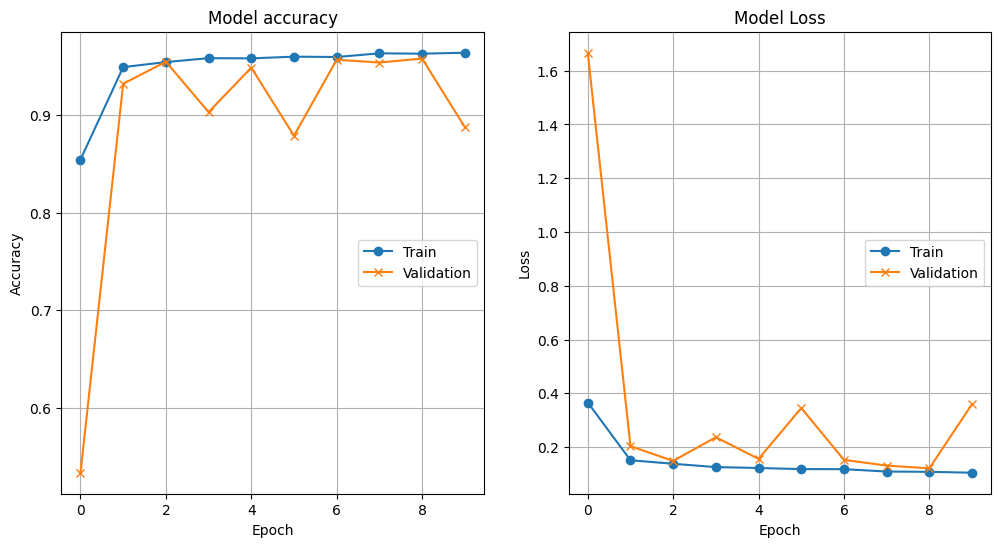

In [ ]:
plot_generator(history_resnet)

In [ ]:
# saving the resnet model for futher use
model_resnet.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/models/model_resnet.h5')
test_loss_resnet,test_acc_resnet=model_resnet.evaluate(X_test,y_test)
print('Test Accuracy of this model is: {:.3f}%'.format(test_acc_resnet*100))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 2s 24ms/step - loss: 0.3068 - accuracy: 0.9031
Test Accuracy of this model is: 90.312%


87/87 [==============================] - 2s 22ms/step


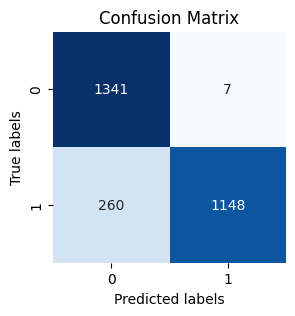

In [ ]:
# loading the saved residual model
model_resnet_l = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Machine Learning/models/model_resnet.h5')
predictions_resnet = model_resnet_l.predict(X_test)
predicted_labels_resnet = np.argmax(predictions_resnet, axis=1)
cm_resnet = confusion_matrix(y_test, predicted_labels_resnet)

# Plotting confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()